https://neuromechfly.org/tutorials/rule_based_controller.html


['LF', 'LM', 'LH', 'RF', 'RM', 'RH']


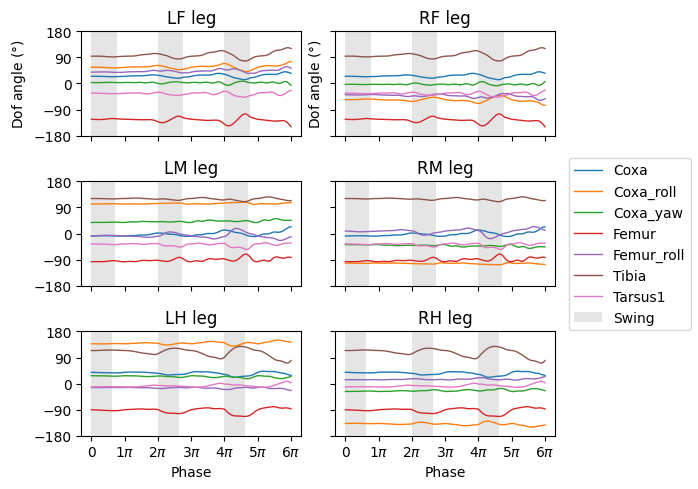

In [24]:
from flygym.examples.locomotion import PreprogrammedSteps
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

output_dir = Path("./outputs/rule_based_controller")
output_dir.mkdir(exist_ok=True, parents=True)

preprogrammed_steps = PreprogrammedSteps()
print(preprogrammed_steps.legs)
theta_ts = np.linspace(0,3*2*np.pi, 100)
r_ts = np.linspace(0,1,100)

fig, axs = plt.subplots(3, 2, figsize=(7, 5), sharex=True, sharey=True)
for i_side, side in enumerate("LR"):
    for i_pos, pos in enumerate("FMH"):
        leg = f"{side}{pos}"
        ax = axs[i_pos, i_side]
        joint_angles = preprogrammed_steps.get_joint_angles(leg, theta_ts, r_ts)
        for i_dof, dof_name in enumerate(preprogrammed_steps.dofs_per_leg):
            legend = dof_name if i_pos == 0 and i_side == 0 else None
            ax.plot(theta_ts, np.rad2deg(joint_angles[i_dof, :]), linewidth=1, label=legend)
        
        for i_cycle in range(3):
            my_swing_period = preprogrammed_steps.swing_period[leg]
            theta_offset = i_cycle * 2 * np.pi
            ax.axvspan(
                theta_offset + my_swing_period[0],
                theta_offset + my_swing_period[0] + my_swing_period[1],
                color="grey",
                linewidth=0,
                alpha=0.2,
                label="Swing" if i_pos == 0 and i_side == 0 and i_cycle == 0 else None,
            )
        if i_pos == 2:
            ax.set_xlabel("Phase")
            ax.set_xticks(np.pi * np.arange(7))
            ax.set_xticklabels(["0" if x == 0 else rf"{x}$\pi$" for x in np.arange(7)])
        if i_pos == 0:
            ax.set_ylabel(r"Dof angle ($\degree$)")

        ax.set_title(f"{leg} leg")
        ax.set_ylim(-180,180)
        ax.set_yticks([-180,-90,0,90,180])
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
fig.savefig(output_dir / "preprogrammed_steps_call.png")
        
    

In [38]:
import networkx as nx

edges = {
    "rule1": {"LM" : ["LF"], "LH": ["LM"], "RM": ["RF"], "RH": ["RM"]},
    "rule2": {
        "LF": ["RF"],
        "LM": ["RM", "LF"],
        "LH": ["RH", "LM"],
        "RF": ["LF"],
        "RM": ["LM", "RF"],
        "RH": ["LH", "RM"],
    },
    "rule3": {
        "LF": ["RF", "LM"],
        "LM": ["RM", "LH"],
        "LH": ["RH"],
        "RF": ["LF", "RM"],
        "RM": ["LM", "RH"],
        "RH": ["LH"],
    },
}

rules_graph = nx.MultiDiGraph()
for rule_type, d in edges.items():
    for src, tgt_nodes in d.items():
        for tgt in tgt_nodes:
            if rule_type == "rule1":
                rule_type_detailed = rule_type
            else:
                side = "ipsi" if src[0] == tgt[0] else "contra"
                rule_type_detailed = f"{rule_type}_{side}"
            rules_graph.add_edge(src, tgt, rule=rule_type_detailed)

def filter_edges(graph, rule, src_node=None):
    return [
        (src, tgt) for src, tgt, rule_type in graph.edges(data="rule")
        if (rule_type == rule) and (src_node is None or src == src_node)    
    ]


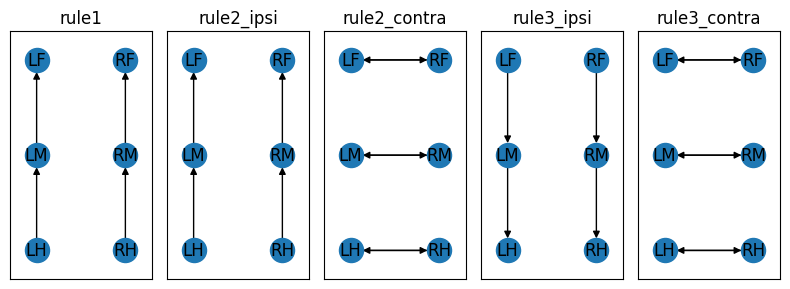

In [40]:
node_pos = {
    "LF": (0,0),
    "LM": (0,1),
    "LH": (0, 2),
    "RF": (1, 0),
    "RM": (1, 1),
    "RH": (1, 2),
}

fig, axs = plt.subplots(1,5, figsize=(8,3), tight_layout=True)
for i, rule in enumerate(["rule1", "rule2_ipsi", "rule2_contra", "rule3_ipsi", "rule3_contra"]):
    ax = axs[i]
    selected_edges = filter_edges(rules_graph, rule)
    nx.draw(rules_graph, pos=node_pos, edgelist=selected_edges, with_labels=True, ax=ax)
    ax.set_title(rule)
    ax.set_xlim(-0.3, 1.3)
    ax.set_ylim(-0.3,2.3)
    ax.invert_yaxis()
    ax.axis("on")
plt.savefig(output_dir / "rules_graph.png")




In [ ]:
class RuleBasedSteppingCoordinator:
    legs = ["LF", "LM", "LH", "RF", "RM", "RH"]

    def __init__(self, timestep, rules_graph, weights, preprogrammed_steps, margin=0.001, seed=0):
        self.timestep = timestep
        self.rules_graph = rules_graph
        self.weights = weights
        self.preprogrammed_steps = preprogrammed_steps
        self.margin = margin
        self.seed= seed
        self.random_state = np.random.RandomState(seed)
        self._phase_inc_per_step = (2*np.pi*(timestep/self.preprogrammed_steps.duration))
        self.curr_step=0
        self.rule1_scores = np.zeros(6)
        self.rule2_scores=np.zeros(6)
        self.rule3_scores=np.zeros(6)
        self.leg_phases = np.zeros(6)
        self.mask_is_stepping = np.zeros(6, dtype=bool)
        self._leg2id = {leg: i for i,leg in enumerate(self.legs)}
        self._id2leg = {i:leg for i,leg in enumerate(self.legs)}

    @property
    def combined_scores(self):
        return self.rule1_scores + self.rule2_scores + self.rule3_scores
    
    def _get_eligible_legs(self):
        score_thr = self.combined_scores.max()
        score_thr = max(0, score_thr - np.abs(score_thr) * self.margin)
        mask_is_eligible = (
            (self.combined_scores >= score_thr)
            & (self.combined_scores > 0)
            & ~self.mask_is_stepping
        )
        return np.where(mask_is_eligible)[0]
    
    def _select_stepping_elg(self):
        eligible_legs = self._get_eligible_legs()
        if len(eligible_legs) == 0:
            return None
        return self.random_state.choice(eligible_legs)
    
    def _apply_rule1(self):
        for i, leg in enumerate(self.legs):
            is_swinging = (
                0 < self.leg_phases[i] < self.preprogrammed_steps.swing_period[leg][1]
            )
            edges = filter_edges(self.rules_graph, "rule1", src_node=leg)
            for _, tgt in edges:
                self.rule1_scores[self._leg2id[tgt]] = (self.weights["rule1"] if is_swinging else 0)


        

